In [1]:
import pickle
import os
import pandas as pd
from datetime import datetime
from collections import Counter
# import hail as hl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bucket = os.getenv("WORKSPACE_BUCKET")

save_path = f'{bucket}/data/aou_demog.csv'
demog = pd.read_csv(save_path)

In [3]:
demog['date_of_birth'] = pd.to_datetime(demog['date_of_birth'], errors = 'coerce')

In [4]:
len(demog['person_id'].unique())

217824

In [5]:
Counter(demog['group'])

Counter({'control': 217209, 'PMS2': 286, 'MSH6': 212, 'MLH1': 63, 'MSH2': 55})

In [6]:
286+212+63+55

616

In [7]:
ages = {}
status = {}
bd = {}
for i,row in tqdm(demog.iterrows(), total = demog.shape[0]):
    ages[row['person_id']] = row['age']
    status[row['person_id']] = row['group']
    bd[row['person_id']] = row['date_of_birth']

100%|██████████| 217825/217825 [00:19<00:00, 11305.01it/s]


In [8]:
Counter(demog['group'])

Counter({'control': 217209, 'PMS2': 286, 'MSH6': 212, 'MLH1': 63, 'MSH2': 55})

In [9]:
mlh1_pat = list(demog[demog['group']=='MLH1'].person_id)
msh2_pat = list(demog[demog['group']=='MSH2'].person_id)
msh6_pat = list(demog[demog['group']=='MSH6'].person_id)
pms2_pat = list(demog[demog['group']=='PMS2'].person_id)

In [10]:
mmr = list(set(mlh1_pat + msh2_pat + msh6_pat + pms2_pat))

In [11]:
len(mmr)

615

In [12]:
615+217209

217824

In [13]:
# pip install openpyxl

In [13]:
agg_df = pd.read_excel('Supplementary Table 2.xlsx')
agg_df = agg_df[['cancer_names','category']]
agg = {}
for i, row in agg_df.iterrows():
    agg[row['cancer_names']] = row['category']

/home/jupyter/.local/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Sheet1!$A:$B.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [14]:
cat = list(agg_df.category.unique())

# cancer conditions for case and control

In [15]:
from google.cloud import storage
import pickle

# Initialize the Google Cloud Storage client
client = storage.Client()

# Define the bucket and the path where your file is stored
bucket_name = 'fc-secure-9b1ab35f-6336-4ab5-aadc-2d39277e3d9b'
file_path = 'data/pat_with_med.pickle'

# Get the bucket
bucket = client.bucket(bucket_name)

# Create a Blob (file) object
blob = bucket.blob(file_path)

# Download the file's content as a bytes object
remove_serialized = blob.download_as_bytes()

# Deserialize the bytes object to get the original data
pat_concepts = pickle.loads(remove_serialized)

In [16]:
pat_with_med = list(pat_concepts.keys())
len(pat_with_med)

163002

In [1]:
pat_with_med = pd.DataFrame(pat_with_med)
pat_with_med.columns = ['person_id'] 
demog_with_med = demog.merge(pat_with_med, on = 'person_id', how = 'inner')
demog_with_med

In [18]:
patids = list(demog_with_med['person_id'].unique())

In [19]:
len(patids)

162970

In [20]:
Counter(demog_with_med[demog_with_med['group']!='control']['group'])

Counter({'PMS2': 205, 'MSH6': 162, 'MLH1': 50, 'MSH2': 40})

In [31]:
num_sublists = len(patids) // 1000 + (1 if len(patids) % 1000 else 0)

sublists = [patids[i * 1000: (i + 1) * 1000] for i in range(num_sublists)]

### demog with med  table

In [20]:
Counter(demog_with_med['ethnicity'])

Counter({'Not Hispanic or Latino': 132471, 'Hispanic or Latino': 30499})

In [21]:
2848+940+165

3953

In [22]:
Counter(demog_with_med[demog_with_med['group']!='control']['ethnicity'])

Counter({'Not Hispanic or Latino': 384, 'Hispanic or Latino': 73})

In [23]:
Counter(demog_with_med[demog_with_med['group']=='control']['ethnicity'])

Counter({'Not Hispanic or Latino': 132087, 'Hispanic or Latino': 30426})

In [114]:
Counter(demog_with_med[demog_with_med['group']=='control']['gender'])

Counter({'Female': 100408, 'Male': 62105})

In [115]:
Counter(demog_with_med[demog_with_med['group']!='control']['gender'])

Counter({'Female': 268, 'Male': 189})

### refine cancer types into 30

In [29]:
dataset = os.getenv("WORKSPACE_CDR")
dat = []
for lst in tqdm(sublists):
    sql = f"""
        SELECT co.person_id, c.concept_name, co.condition_start_date
        FROM `{dataset}.condition_occurrence` co
        JOIN `{dataset}.concept` c ON co.condition_concept_id = c.concept_id
        WHERE co.person_id IN ({', '.join(map(str, lst))})
    """

    concepts = pd.read_gbq(
        sql,
        dialect="standard",
        use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ))

    concepts['condition_start_date'] = pd.to_datetime(concepts['condition_start_date'], errors = 'coerce')

    concepts = concepts.rename(columns={"concept_name": "cancer_names"})
    concepts['cancer_names'] = concepts['cancer_names'].apply(str.lower)
    concepts_cancer = concepts.merge(agg_df, on = 'cancer_names', how = 'inner')

    grk = concepts_cancer.groupby('person_id')
    ids = list(concepts_cancer.person_id.unique())
    for i in ids:
        pat_dat = grk.get_group(i)
        pat_dat_grk = pat_dat.groupby('category')
        pat_dat_cat_collect = []
        for c in cat:
            if c in list(pat_dat.category):
                pat_dat_cat = pat_dat_grk.get_group(c)
                pat_dat_cat = pat_dat_cat.sort_values(by=['condition_start_date'])
                pat_dat_cat_collect.append(pat_dat_cat.iloc[0,:])
        dat.append(pd.DataFrame(pat_dat_cat_collect))

100%|██████████| 163/163 [42:06<00:00, 15.50s/it] 


In [30]:
# SAVE

# from google.cloud import storage
# import pickle
# import io

# # Initialize the Google Cloud Storage client
# client = storage.Client()

# # Define the bucket and the path where you want to save the file
# bucket_name = 'fc-secure-9b1ab35f-6336-4ab5-aadc-2d39277e3d9b'
# file_path = 'data/cancer_refined.pickle'

# # Get the bucket
# bucket = client.bucket(bucket_name)

# # Create a Blob (file) object
# blob = bucket.blob(file_path)

# # Serialize your object to a bytes object using pickle
# remove_serialized = pickle.dumps(dat)

# # Upload the serialized object to the bucket
# blob.upload_from_string(remove_serialized, content_type='application/octet-stream')

In [21]:
# LOAD

from google.cloud import storage
import pickle

# Initialize the Google Cloud Storage client
client = storage.Client()

# Define the bucket and the path where your file is stored
bucket_name = 'fc-secure-9b1ab35f-6336-4ab5-aadc-2d39277e3d9b'
file_path = 'data/cancer_refined.pickle'

# Get the bucket
bucket = client.bucket(bucket_name)

# Create a Blob (file) object
blob = bucket.blob(file_path)

# Download the file's content as a bytes object
remove_serialized = blob.download_as_bytes()

# Deserialize the bytes object to get the original data
dat = pickle.loads(remove_serialized)

In [22]:
case_ctrl_cancer = pd.concat(dat)

In [23]:
len(case_ctrl_cancer)

36394

In [24]:
len(case_ctrl_cancer['person_id'].unique())

25327

In [25]:
case_ctrl_cancer_demog = case_ctrl_cancer.merge(demog[['person_id', 'group']], on = 'person_id', how = 'inner')

In [26]:
len(case_ctrl_cancer_demog)

36394

In [2]:
# case_ctrl_cancer_demog

# LS associated cancers

In [28]:
LScancer = ['colon/rectal','stomach','small intestine', 'uterine/endometrial','ovarian','hepatobiliary','urinary tract/bladder',
         'pancreas', 'prostate']

In [29]:
case_ctrl_LScancer = case_ctrl_cancer_demog[case_ctrl_cancer_demog['category'].isin(LScancer)]

In [31]:
ctrl_LScancer = case_ctrl_LScancer[case_ctrl_LScancer['group'] == 'control']
case_LScancer = case_ctrl_LScancer[case_ctrl_LScancer['group'] != 'control']

In [32]:
print(len(ctrl_LScancer))
print(len(ctrl_LScancer['person_id'].unique()))

print(len(case_LScancer))
print(len(case_LScancer['person_id'].unique()))

10423
9278
124
90


In [3]:
# Counter(case_LScancer['category'])

In [35]:
Counter(ctrl_LScancer['category'])

Counter({'prostate': 4060,
         'colon/rectal': 2009,
         'urinary tract/bladder': 1155,
         'uterine/endometrial': 957,
         'ovarian': 776,
         'pancreas': 508,
         'hepatobiliary': 500,
         'stomach': 355,
         'small intestine': 103})

In [36]:
4060+1155+776+508+500+355+103

7457

In [37]:
def LScancer_num(dat, num_cancer = 1):
    grk = dat.groupby('person_id')
    patids = list(dat['person_id'].unique())

    can1, can2, can3plus = [], [], []
    for i in patids:
        count = len(grk.get_group(i))
        if count==1:
            can1.append(i)
        elif count==2:
            can2.append(i)
        else:
            can3plus.append(i)

    print('1 LS cancer:', len(can1))
    print('2 LS cancer:', len(can2))
    print('>=3 LS cancer:', len(can3plus))
    
    if num_cancer == 1:
        num_can = can1
    elif num_cancer ==2:
        num_can = can2
    else:
        num_can = can3plus
        
    data_of_interest = demog[demog['person_id'].isin(num_can)]['age']
    print('current age median:', np.median(data_of_interest))
    print('current age min:',np.min(data_of_interest))
    print('current age max:',np.max(data_of_interest))

    ageAtd = []
    for i, row in dat.iterrows():
        ageAtd.append((row['condition_start_date']-bd[row['person_id']])/np.timedelta64(1, 'Y'))

    dat.loc[:,'age_at_diag'] = ageAtd
    data_of_interest = dat[dat['person_id'].isin(num_can)]['age_at_diag']
    print('age at diag median:',np.median(data_of_interest))
    print('age at diag min:',np.min(data_of_interest))
    print('age at diag max:', np.max(data_of_interest))

In [4]:
# case_LScancer

In [5]:
# LScancer_num(case_LScancer)

In [43]:
LScancer_num(ctrl_LScancer)

1 LS cancer: 8277
2 LS cancer: 879
>=3 LS cancer: 122
current age median: 73.0515454595171
current age min: 21.015929021160925
current age max: 108.07346326773629
age at diag median: 64.2931506849315
age at diag min: 7.47945205479452
age at diag max: 105.23013698630137


/tmp/ipykernel_119/3290108452.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
# LScancer_num(pd.concat([case_LScancer, ctrl_LScancer]))

In [7]:
# LScancer_num(pd.concat([case_LScancer, ctrl_LScancer]), num_cancer=2)

In [8]:
# LScancer_num(pd.concat([case_LScancer, ctrl_LScancer]), num_cancer = 3)

In [9]:
# ctrl_LScancer[ctrl_LScancer['age_at_diag']<18]

In [48]:
115+27350

27465

# nonLS associated cancers

In [40]:
case_ctrl_nonLScancer = case_ctrl_cancer[~case_ctrl_cancer['category'].isin(LScancer)]

In [10]:
# case_ctrl_nonLScancer

In [42]:
case_ctrl_nonLScancer = case_ctrl_nonLScancer.merge(demog[['person_id', 'group']], on = 'person_id', how = 'inner')

In [43]:
case_nonLScancer = case_ctrl_nonLScancer[case_ctrl_nonLScancer['group']!='control']
ctrl_nonLScancer = case_ctrl_nonLScancer[case_ctrl_nonLScancer['group']=='control']

In [44]:
print(len(case_nonLScancer['person_id'].unique()))
print(len(ctrl_nonLScancer['person_id'].unique()))

76
19088


In [45]:
print(len(set(list(case_nonLScancer['person_id'].unique()))-set(list(case_LScancer['person_id'].unique()))))
print(len(set(list(ctrl_nonLScancer['person_id'].unique()))-set(list(ctrl_LScancer['person_id'].unique()))))

37
15922


In [46]:
patlist_case_med = list(demog_with_med[demog_with_med['group']!='control']['person_id'])
patlist_ctrl_med = list(demog_with_med[demog_with_med['group']=='control']['person_id'])

patlist_case_LScancer = list(case_LScancer['person_id'])
patlist_ctrl_LScancer = list(ctrl_LScancer['person_id'])
patlist_case_nonLScancer = list(case_nonLScancer['person_id'])
patlist_ctrl_nonLScancer = list(ctrl_nonLScancer['person_id'])

In [47]:
nocancer_case = set(patlist_case_med)-set(patlist_case_LScancer)-set(patlist_case_nonLScancer)
len(nocancer_case)

330

In [48]:
nocancer_ctrl = set(patlist_ctrl_med)-set(patlist_ctrl_LScancer)-set(patlist_ctrl_nonLScancer)
len(nocancer_ctrl)

137313

# Table 1 statistics

### Z test

In [111]:
# use a Z-test for proportions when your primary goal is to compare the proportion of a single characteristic between 
# two groups. Use a Chi-squared test when you want to examine the relationship or association between 
# two categorical variables, often represented in a contingency table.

In [117]:
import statsmodels.api as sm

In [122]:
# Sample data
count = [303, 97108]  # Number of successes (e.g., number of males) in each group
nobs = [457, 162513]   # Total number of observations in each group

z, p = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic: {z}")
print(f"P-value: {p}")

alpha = 0.05
if p < alpha:
    print("The proportions of gender between the two groups are statistically significantly different.")
else:
    print("There's no statistically significant difference in gender proportions between the groups.")

Z-statistic: 2.850645414834033
P-value: 0.004363059493622227
The proportions of gender between the two groups are statistically significantly different.


### Chi squred and odds ratio

In [1]:
import numpy as np
from scipy.stats import chi2_contingency

# Example data: [Cancer, No Cancer]
# c_tot = 457
# nc_tot = 162513

# c=52
# nc = 7457

c_tot = 268
nc_tot = 100408

c=25
nc = 957

# c_tot = 237
# nc_tot = 81221

# c=34
# nc = 2107

data = np.array([
    [nc, nc_tot-nc],  # Non-carriers
    [c, c_tot-c]    # Carriers
])

# Calculate the odds ratio
odds_ratio = (c * (nc_tot-nc)) / ((c_tot-c) * nc)

# Calculate the 95% confidence interval for the odds ratio
se_log_or = np.sqrt(1/c + 1/(c_tot-c) + 1/nc + 1/(nc_tot-nc))
ci_lower = np.exp(np.log(odds_ratio) - 1.96 * se_log_or)
ci_upper = np.exp(np.log(odds_ratio) + 1.96 * se_log_or)

print(f"Odds Ratio: {odds_ratio}")
print(f"95% Confidence Interval: [{ci_lower}, {ci_upper}]")

# Perform Chi-square test
chi2, pvalue, dof, expected = chi2_contingency(data)

print(f"chi2: {chi2}")
print(f"pvalue: {pvalue}")
# print(f"Degrees of Freedom: {dof}")
# print("Expected Frequencies:")
# print(expected)

Odds Ratio: 10.691310723239203
95% Confidence Interval: [7.048867302884564, 16.215956418143037]
chi2: 185.5339981929277
pvalue: 3.000699124274894e-42


# cumulative probability of having cancer

In [61]:
ageAtd = []
for i, row in case_ctrl_cancer_demog.iterrows():
    ageAtd.append((row['condition_start_date']-bd[row['person_id']])/np.timedelta64(1, 'Y'))

case_ctrl_cancer_demog.loc[:,'age_at_diag'] = ageAtd

In [11]:
# case_ctrl_cancer_demog

In [63]:
len(case_ctrl_cancer_demog['person_id'].unique())

25327

In [64]:
case_ctrl_LScancer = case_ctrl_cancer_demog[case_ctrl_cancer_demog['category'].isin(LScancer)]

In [65]:
# first cancer only
def first_cancer(dat):
    grk = dat.groupby('person_id')
    patids = list(dat['person_id'].unique())
    first_cancer = []
    for i in tqdm(patids):
        dat = grk.get_group(i)
        dat = dat.sort_values(by='age_at_diag').iloc[0,:]
        first_cancer.append(dat)
    return pd.DataFrame(first_cancer)

In [66]:
case_ctrl_LScancer = case_ctrl_LScancer[['person_id']].merge(case_ctrl_cancer_demog, on='person_id', how = 'inner')

In [67]:
LScancer_group = first_cancer(case_ctrl_LScancer)

100%|██████████| 9368/9368 [00:10<00:00, 930.19it/s] 


In [68]:
len(LScancer_group)

9368

In [69]:
nonLScancer_patids = list(set(list(case_ctrl_cancer_demog['person_id'].unique()))-set(list(LScancer_group.person_id)))

In [70]:
len(nonLScancer_patids)

15959

In [71]:
nonLScancer_patids = pd.DataFrame(nonLScancer_patids)
nonLScancer_patids.columns = ['person_id']
nonLScancer_group = first_cancer(nonLScancer_patids.merge(case_ctrl_cancer_demog, on='person_id', how = 'inner'))

100%|██████████| 15959/15959 [00:15<00:00, 1043.84it/s]


In [72]:
len(nonLScancer_group)

15959

In [73]:
all_cancer_group = pd.concat([LScancer_group, nonLScancer_group])

In [12]:
# Counter(LScancer_group['group'])

In [50]:
def cumulative_prob(dat):
    frequency = dat['age_at_diag'].value_counts().sort_index()
    cumulative_frequency = frequency.cumsum()
    cumulative_probability = cumulative_frequency / cumulative_frequency.iloc[-1]
    return cumulative_probability 

In [51]:
age_diag = all_cancer_group[all_cancer_group['group']!='control']
age_diag_control = all_cancer_group[all_cancer_group['group']=='control']

print(len(age_diag))
print(len(age_diag_control))

127
25200


In [52]:
print(np.median(age_diag['age_at_diag']))
print(np.median(age_diag_control['age_at_diag']))

59.64109589041096
60.489041095890414


LS carrier
at age50 0.23622047244094488
at age65 0.7086614173228346
nonLS carrier
at age50 0.22845238095238096
at age65 0.643452380952381


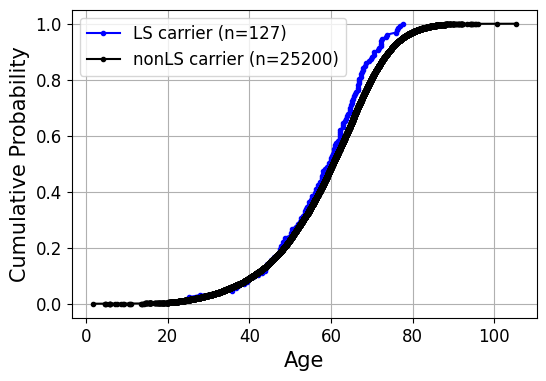

In [71]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'b', label = 'LS carrier (n=127)')
print('LS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age65', cumulative_probability[cumulative_probability.index <= 65].iloc[-1])

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier (n=25200)')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age65', cumulative_probability[cumulative_probability.index <= 65].iloc[-1])

plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('All cancers', fontsize = 15)

plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

nonLS carrier
at age50 0.22845238095238096
at age70 0.8041666666666667
MLH1
at age50 0.42105263157894735
at age70 0.9473684210526315
MSH2
at age50 0.25
at age70 0.9
MSH6
at age50 0.20454545454545456
at age70 0.8409090909090909
PMS2
at age50 0.18181818181818182
at age70 0.8863636363636364


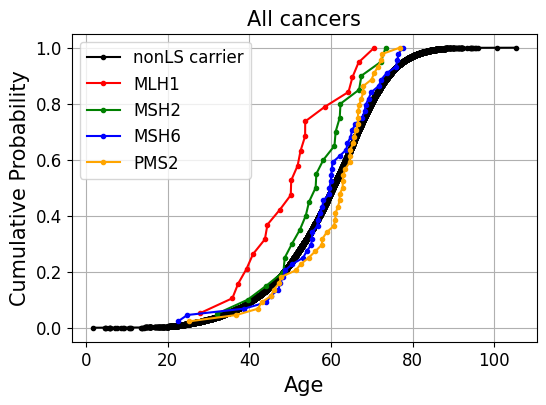

In [144]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age70', cumulative_probability[cumulative_probability.index <= 70].iloc[-1])

col = ['r', 'g', 'b', 'orange']
ii=0
for i in ['MLH1','MSH2','MSH6','PMS2']:
    cumulative_probability = cumulative_prob(age_diag[age_diag['group']==i])
    plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', label = i, color = col[ii])
    print(i)
    print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
    print('at age70', cumulative_probability[cumulative_probability.index <= 70].iloc[-1])
    ii=ii+1
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('All cancers', fontsize = 15)

plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

### by LS cancers

In [63]:
age_diag = LScancer_group[LScancer_group['group']!='control']
age_diag_control = LScancer_group[LScancer_group['group']=='control']

In [146]:
print(np.median(age_diag['age_at_diag']))
print(np.median(age_diag_control['age_at_diag']))

58.01780821917808
63.345205479452055


In [147]:
print(len(age_diag))
print(len(age_diag_control))

90
9278


LS carrier
at age50 0.25555555555555554
at age65 0.7333333333333333
nonLS carrier
at age50 0.1391463677516706
at age70 0.7602931666307394


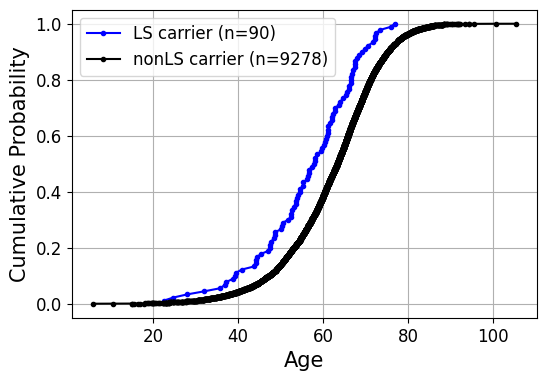

In [148]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'b', label = 'LS carrier (n=90)')
print('LS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age65', cumulative_probability[cumulative_probability.index <= 65].iloc[-1])

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier (n=9278)')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age70', cumulative_probability[cumulative_probability.index <= 70].iloc[-1])

plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(fontsize = 12)

plt.show()

nonLS carrier
at age50 0.1391463677516706
at age70 0.7600776029316663
MLH1
at age50 0.4444444444444444
at age70 0.9444444444444444
MSH2
at age50 0.2777777777777778
at age70 0.8888888888888888
MSH6
at age50 0.2413793103448276
at age70 0.9310344827586207
PMS2
at age50 0.12
at age70 0.88


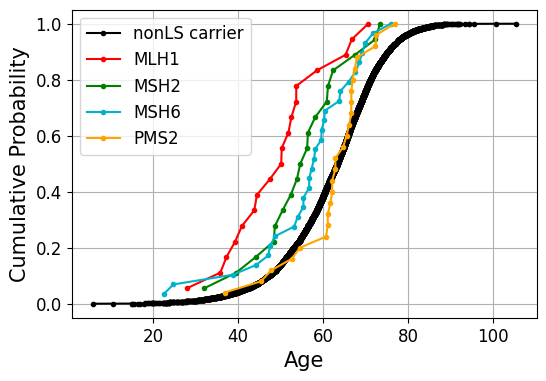

In [149]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index < 50].iloc[-1])
print('at age70', cumulative_probability[cumulative_probability.index <70].iloc[-1])

num = [18,17,29,21]
col = ['r', 'g', '#00b3ca', 'orange']

ii=0
for i in ['MLH1','MSH2','MSH6','PMS2']:
    cumulative_probability = cumulative_prob(age_diag[age_diag['group']==i])
    plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', label = i, color = col[ii])
    print(i)
    print('at age50', cumulative_probability[cumulative_probability.index < 50].iloc[-1])
    print('at age70', cumulative_probability[cumulative_probability.index <70].iloc[-1])
    ii=ii+1
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(fontsize = 12)
# plt.title(cancer[ii], fontsize = 15)
# plt.title('LS-associated cancers', fontsize = 15)
plt.show()

# survival analysis

In [54]:
# pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from itertools import combinations

kmf = KaplanMeierFitter()

In [78]:
col = ['r', 'g', '#00b3ca', 'orange']
def plot_surv(dat, p ='P<0.0001', p1 = 'P<0.0001', p2= 'P<0.0001', p3= 'P<0.0001', p4= 'P<0.0001'):
    lst = list(dat['age_at_diag'])
    event = [1 if not np.isnan(x) else 0 for x in lst]

    time2event = [a2 if not np.isnan(a2) else a1 for a1, a2 in zip(dat['age'], dat['age_at_diag'])]

    dat['event'] = event
    dat['time_to_event'] = time2event

    plt.figure(figsize=(6,4))

    mask_ls = dat['group'] != 'control'
    kmf.fit(dat['time_to_event'][mask_ls], event_observed=dat['event'][mask_ls], label='LS Carrier' +', '+p)
    ax = kmf.plot(ci_show=True, show_censors = True, ci_legend = True, color = 'b')

    # # For non-carriers
    mask_non_carrier = dat['group'] == 'control'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Non-Carrier')
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color ='k')

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()

    plt.figure(figsize=(6,4))

    ###################################################################################
    mask_non_carrier = dat['group'] == 'control'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Non-Carrier')
    ax = kmf.plot(ci_show=True, show_censors = True, ci_legend = True, color = 'k')

    mask_mlh1 = dat['group'] == 'MLH1'
    kmf.fit(dat['time_to_event'][mask_mlh1], event_observed=dat['event'][mask_mlh1], label='MLH1' +', '+p1)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[0])

    mask_msh2 = dat['group'] == 'MSH2'
    kmf.fit(dat['time_to_event'][mask_msh2], event_observed=dat['event'][mask_msh2], label='MSH2' +', '+p2)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[1])

    mask_msh6 = dat['group'] == 'MSH6'
    kmf.fit(dat['time_to_event'][mask_msh6], event_observed=dat['event'][mask_msh6], label='MSH6' +', '+p3)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[2])

    mask_pms2 = dat['group'] == 'PMS2'
    kmf.fit(dat['time_to_event'][mask_pms2], event_observed=dat['event'][mask_pms2], label='PMS2' +', '+p4)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[3])

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()
    
    results_ = logrank_test(dat['time_to_event'][mask_ls], dat['time_to_event'][mask_non_carrier], 
                       event_observed_A=dat['event'][mask_ls], event_observed_B=dat['event'][mask_non_carrier])
    
    p_value = results_.p_value
    print(f"P-value: {p_value}")
    
    df = dat.copy(deep = True)
    genes = df['group'].unique()
    for (gene1, gene2) in combinations(genes, 2):
        results = logrank_test(
            df['time_to_event'][df['group'] == gene1], 
            df['time_to_event'][df['group'] == gene2], 
            event_observed_A=df['event'][df['group'] == gene1], 
            event_observed_B=df['event'][df['group'] == gene2]
        )
        print(f"Comparison between {gene1} and {gene2}: p = {results.p_value}")
    return results_

### all cancer

In [79]:
data_surv = demog_with_med.merge(all_cancer_group[['person_id', 'age_at_diag', 'category']], on = 'person_id', how = 'outer')

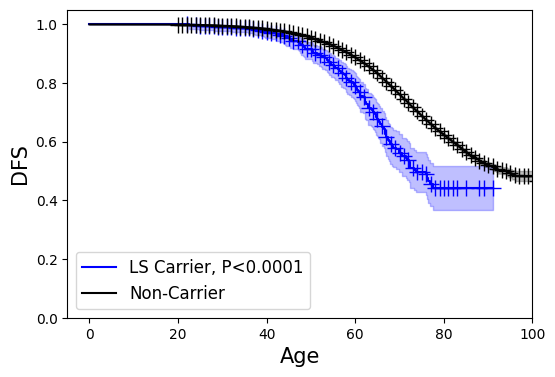

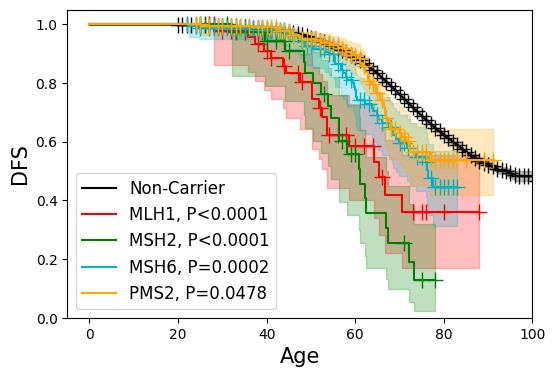

P-value: 3.5471539004712225e-13
Comparison between MLH1 and MSH2: p = 0.4425736083745725
Comparison between MLH1 and MSH6: p = 0.012506748522485064
Comparison between MLH1 and PMS2: p = 0.00031720161691212135
Comparison between MLH1 and control: p = 6.68038796174481e-09
Comparison between MSH2 and MSH6: p = 9.534500303943344e-05
Comparison between MSH2 and PMS2: p = 3.51353838222496e-07
Comparison between MSH2 and control: p = 1.0020551335847534e-15
Comparison between MSH6 and PMS2: p = 0.24332664264668719
Comparison between MSH6 and control: p = 0.0001668606863451496
Comparison between PMS2 and control: p = 0.0477876614024845


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          52.88 <0.005     41.36

In [80]:
plot_surv(data_surv, p3 = 'P=0.0002', p4 = 'P=0.0478')

### LS cancer

In [13]:
# Counter(LScancer_group['category']) #individuals diagnosed with LScancer may also have other cancers before or after

In [82]:
no_cancer_group = data_surv[data_surv['event']==0][list(demog_with_med.columns)]

In [83]:
data_surv_LS = pd.concat([no_cancer_group[['person_id','age','group']], LScancer_group[['person_id','group','age_at_diag']]])

In [84]:
Counter(data_surv_LS['group'])

Counter({'control': 146591, 'PMS2': 186, 'MSH6': 147, 'MLH1': 49, 'MSH2': 38})

In [164]:
202+147+49+38

436

In [165]:
9278+137321

146599

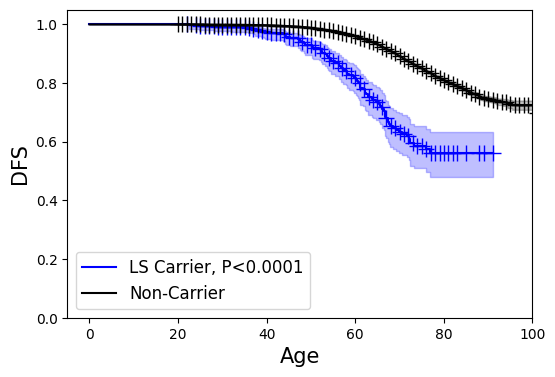

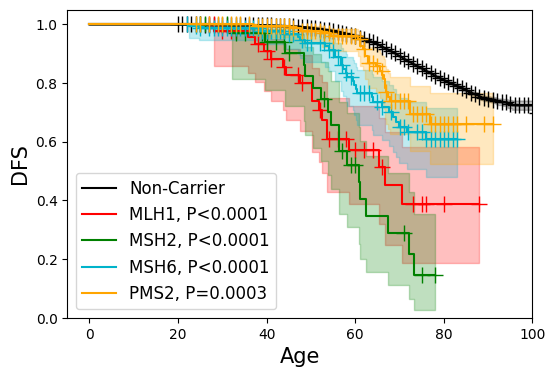

P-value: 2.820177798496842e-39
Comparison between MLH1 and MSH2: p = 0.45700682991767716
Comparison between MLH1 and MSH6: p = 0.0023657469451925602
Comparison between MLH1 and PMS2: p = 8.255298886468688e-07
Comparison between MLH1 and control: p = 7.285589771596012e-29
Comparison between MSH2 and MSH6: p = 1.7379714673840192e-05
Comparison between MSH2 and PMS2: p = 9.205884948251466e-11
Comparison between MSH2 and control: p = 2.906604522265447e-46
Comparison between MSH6 and PMS2: p = 0.0931966600923359
Comparison between MSH6 and control: p = 2.5464797349111605e-11
Comparison between PMS2 and control: p = 0.00027102174122116575


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         171.92 <0.005    128.06

In [167]:
plot_surv(data_surv_LS, p4 = 'P=0.0003')

### LS cancer types

In [168]:
LScancer

['colon/rectal',
 'stomach',
 'small intestine',
 'uterine/endometrial',
 'ovarian',
 'hepatobiliary',
 'urinary tract/bladder',
 'pancreas',
 'prostate']

In [169]:
crc = LScancer_group[LScancer_group['category']=='colon/rectal']
ue = LScancer_group[LScancer_group['category']=='uterine/endometrial']
crc_ue = pd.concat([crc, ue])
others = LScancer_group.merge(crc_ue, on=list(crc.columns), how='outer', indicator=True)

# Keep only rows present in the original DataFrame and not in the sub-DataFrame
others = others[others['_merge'] == 'left_only'].drop(columns=['_merge'])

In [170]:
print(len(LScancer_group))
print(len(crc))
print(len(ue))
print(len(others))

9368
1481
694
7193


In [171]:
1856+860+6652

9368

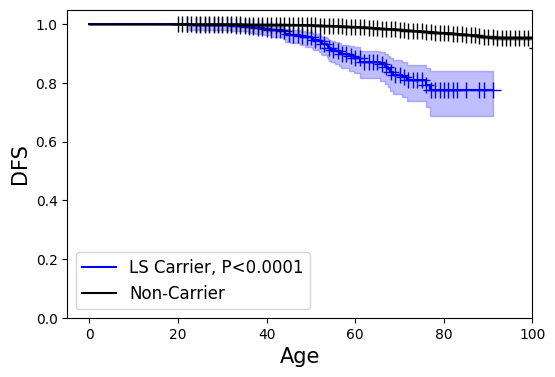

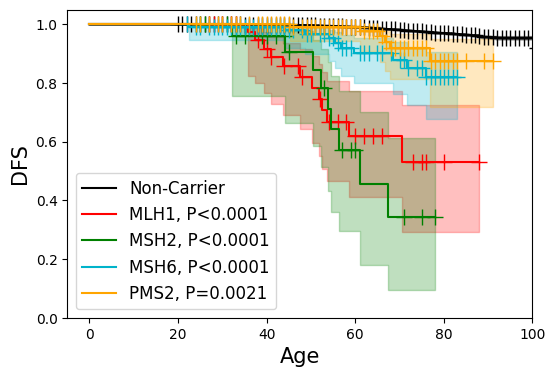

P-value: 3.409504963126777e-67
Comparison between MLH1 and MSH2: p = 0.6521730418583831
Comparison between MLH1 and MSH6: p = 0.00017521565850438074
Comparison between MLH1 and PMS2: p = 4.342975889395022e-09
Comparison between MLH1 and control: p = 2.8815604950051105e-94
Comparison between MSH2 and MSH6: p = 7.546584246357093e-06
Comparison between MSH2 and PMS2: p = 9.32071894473918e-12
Comparison between MSH2 and control: p = 2.2780399925555633e-104
Comparison between MSH6 and PMS2: p = 0.11720046498490228
Comparison between MSH6 and control: p = 3.608042008469705e-14
Comparison between PMS2 and control: p = 0.0021057291770285114


In [173]:
data_surv_LSspec = pd.concat([no_cancer_group[['person_id','age','group']], crc[['person_id','group','age_at_diag']]])
stat = plot_surv(data_surv_LSspec, p4 = 'P=0.0021')

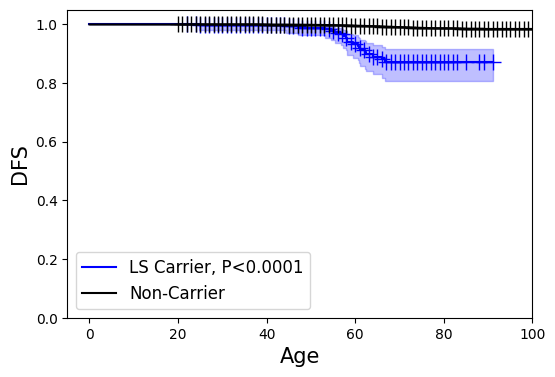

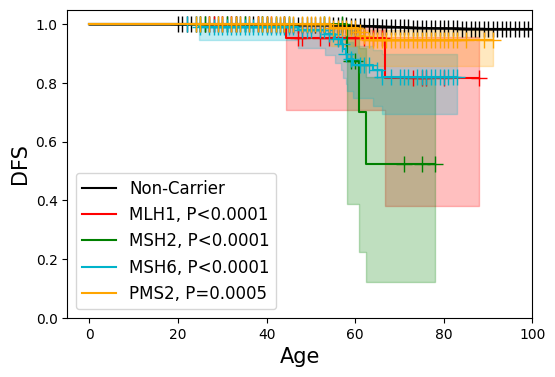

P-value: 2.072637799788584e-45
Comparison between MLH1 and MSH2: p = 0.21270110109208162
Comparison between MLH1 and MSH6: p = 0.7226014791405886
Comparison between MLH1 and PMS2: p = 0.14931016180142725
Comparison between MLH1 and control: p = 3.151239111542394e-07
Comparison between MSH2 and MSH6: p = 0.243383771626845
Comparison between MSH2 and PMS2: p = 0.000204590681484879
Comparison between MSH2 and control: p = 3.940908083533195e-29
Comparison between MSH6 and PMS2: p = 0.011105786663537884
Comparison between MSH6 and control: p = 1.2700045102506021e-39
Comparison between PMS2 and control: p = 0.0004941901927382616


In [175]:
data_surv_LSspec = pd.concat([no_cancer_group[['person_id','age','group']], ue[['person_id','group','age_at_diag']]])
stat = plot_surv(data_surv_LSspec, p4 = 'P=0.0005')

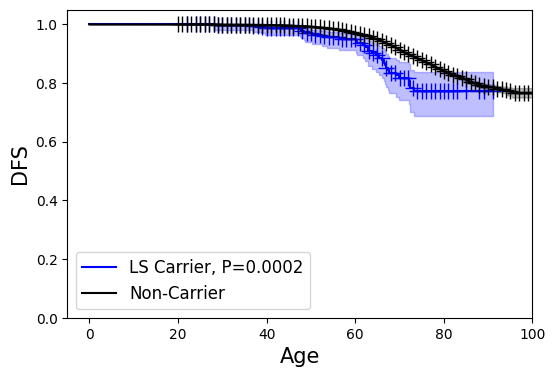

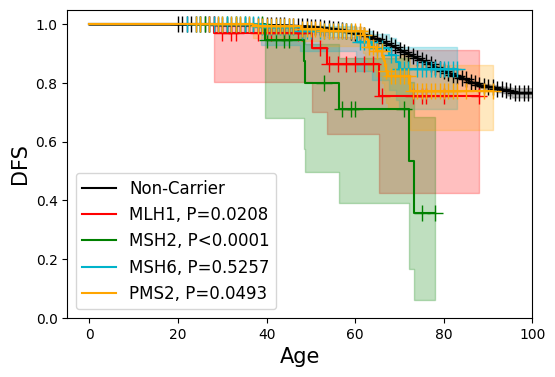

P-value: 0.00023644621264146037
Comparison between MLH1 and MSH2: p = 0.17297164920744726
Comparison between MLH1 and MSH6: p = 0.15123858795641587
Comparison between MLH1 and PMS2: p = 0.27146528066773795
Comparison between MLH1 and control: p = 0.020815887385989267
Comparison between MSH2 and MSH6: p = 0.0005731204783342655
Comparison between MSH2 and PMS2: p = 0.001423904256654699
Comparison between MSH2 and control: p = 1.8888684863915553e-09
Comparison between MSH6 and PMS2: p = 0.48653653456689183
Comparison between MSH6 and control: p = 0.5256957940998344
Comparison between PMS2 and control: p = 0.04931215931079287


In [177]:
data_surv_LSspec = pd.concat([no_cancer_group[['person_id','age','group']], others[['person_id','group','age_at_diag']]])
stat = plot_surv(data_surv_LSspec, p = 'P=0.0002', p1 = 'P=0.0208', p2 = 'P<0.0001', p3 = 'P=0.5257', p4 = 'P=0.0493')

# LS fam

In [85]:
def plot_surv(dat, p ='P<0.0001', p1 = 'P<0.0001', p2= 'P<0.0001', p3= 'P<0.0001', p4= 'P<0.0001'):
    lst = list(dat['age_at_diag'])
    event = [1 if not np.isnan(x) else 0 for x in lst]

    time2event = [a2 if not np.isnan(a2) else a1 for a1, a2 in zip(dat['age'], dat['age_at_diag'])]

    dat['event'] = event
    dat['time_to_event'] = time2event

    plt.figure(figsize=(6,4))

    mask_ls = dat['fam_yes'] == 'yes'
    kmf.fit(dat['time_to_event'][mask_ls], event_observed=dat['event'][mask_ls], label='With family history' +', '+p)
    ax = kmf.plot(ci_show=True, show_censors = True, ci_legend = True, color = 'b')

    # # For non-carriers
    mask_non_carrier = dat['fam_yes'] == 'no'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Unknown family history')
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color ='k')

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()
    
    results_ = logrank_test(dat['time_to_event'][mask_ls], dat['time_to_event'][mask_non_carrier], 
                       event_observed_A=dat['event'][mask_ls], event_observed_B=dat['event'][mask_non_carrier])

    plt.figure(figsize=(6,4))

    # # For non-carriers
    mask_non_carrier = dat['fam_yes'] == 'no'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Unknown family history')
    ax = kmf.plot(ci_show=True, show_censors=True, ci_legend=True, color ='k')

    dat = dat[dat['fam_yes'] == 'yes']
    mask_mlh1 = dat['group'] == 'MLH1'
    kmf.fit(dat['time_to_event'][mask_mlh1], event_observed=dat['event'][mask_mlh1], label='MLH1' +', '+p1)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[0])

    mask_msh2 =  dat['group'] == 'MSH2'
    kmf.fit(dat['time_to_event'][mask_msh2], event_observed=dat['event'][mask_msh2], label='MSH2' +', '+p2)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[1])

    mask_msh6 =  dat['group'] == 'MSH6'
    kmf.fit(dat['time_to_event'][mask_msh6], event_observed=dat['event'][mask_msh6], label='MSH6' +', '+p3)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[2])

    mask_pms2 =  dat['group'] == 'PMS2'
    kmf.fit(dat['time_to_event'][mask_pms2], event_observed=dat['event'][mask_pms2], label='PMS2' +', '+p4)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[3])

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()
    
    p_value = results_.p_value
    print(f"P-value: {p_value}")
    
    df = dat.copy(deep = True)
    df = df[df['fam_yes']=='yes']
    genes = df['group'].unique()
    for (gene1, gene2) in combinations(genes, 2):
        results = logrank_test(
            df['time_to_event'][df['group'] == gene1], 
            df['time_to_event'][df['group'] == gene2], 
            event_observed_A=df['event'][df['group'] == gene1], 
            event_observed_B=df['event'][df['group'] == gene2]
        )
        print(f"Comparison between {gene1} and {gene2}: p = {results.p_value}")
    return results_

### all cancer

In [86]:
bucket = os.getenv("WORKSPACE_BUCKET")
save_path = f'{bucket}/data/LS_fam.csv'
LSfam = pd.read_csv(save_path)

save_path = f'{bucket}/data/nonLS_fam.csv'
nonLSfam = pd.read_csv(save_path)

In [87]:
fam_yes = pd.concat([LSfam, nonLSfam])
fam_yes['fam_yes'] = 'yes'

In [88]:
len(fam_yes)

27642

In [89]:
data_surv_fam = data_surv.merge(fam_yes[['person_id','fam_yes']], on = 'person_id', how = 'outer')

In [90]:
data_surv_fam['fam_yes'] = data_surv_fam['fam_yes'].fillna('no')

In [91]:
Counter(data_surv_fam['fam_yes'])

Counter({'no': 135328, 'yes': 27642})

In [92]:
135328+27642

162970

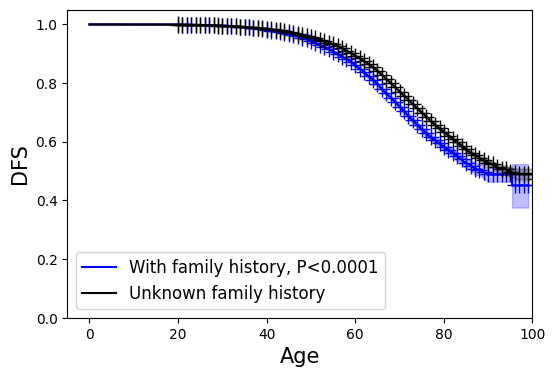

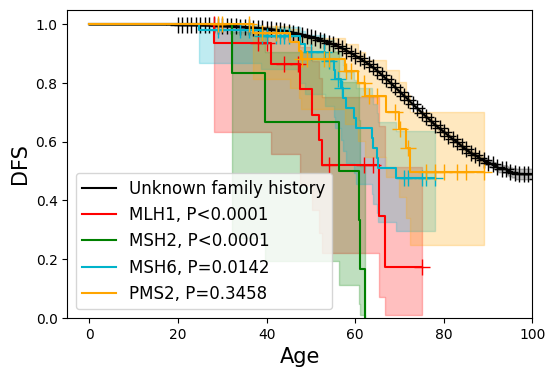

P-value: 8.326438326486113e-50
Comparison between MLH1 and MSH2: p = 0.1370127572240122
Comparison between MLH1 and MSH6: p = 0.07573665923781014
Comparison between MLH1 and PMS2: p = 0.013880069014719592
Comparison between MLH1 and control: p = 3.4192294604844604e-06
Comparison between MSH2 and MSH6: p = 0.002604235296335327
Comparison between MSH2 and PMS2: p = 7.160331972845617e-05
Comparison between MSH2 and control: p = 1.9970049741972388e-11
Comparison between MSH6 and PMS2: p = 0.44965890299280775
Comparison between MSH6 and control: p = 0.014171182685688087
Comparison between PMS2 and control: p = 0.34581395012084604


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         220.16 <0.005    163.04

In [93]:
plot_surv(data_surv_fam, p3='P=0.0142', p4='P=0.3458')

### LS cancer

In [94]:
data_surv_LS_fam = data_surv_fam.merge(data_surv_LS[['person_id']], on = 'person_id', how = 'inner')

In [14]:
# data_surv_LS_fam

In [15]:
# Counter(data_surv_LS_fam['category'])

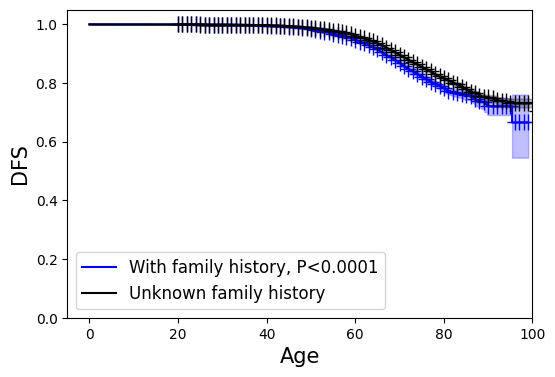

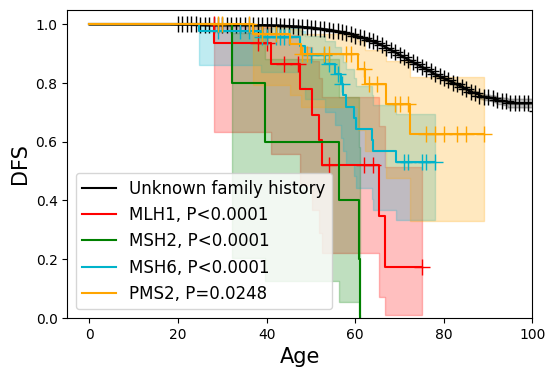

P-value: 3.3292768682384067e-22
Comparison between MLH1 and MSH2: p = 0.12032772644216212
Comparison between MLH1 and MSH6: p = 0.05382282035465714
Comparison between MLH1 and PMS2: p = 0.005218031190854671
Comparison between MLH1 and control: p = 3.2769351951661846e-19
Comparison between MSH2 and MSH6: p = 0.002175150611760223
Comparison between MSH2 and PMS2: p = 1.1975011210449887e-05
Comparison between MSH2 and control: p = 9.827911959583154e-34
Comparison between MSH6 and PMS2: p = 0.26911904793773134
Comparison between MSH6 and control: p = 7.430303710426236e-08
Comparison between PMS2 and control: p = 0.02482773356388915


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          93.89 <0.005     71.35

In [97]:
plot_surv(data_surv_LS_fam, p4 = 'P=0.0248')

In [710]:
test = data_surv_LS_fam[~pd.isna(data_surv_LS_fam['category'])]
Counter(test['fam_yes'])

Counter({'no': 7227, 'yes': 2141})

In [16]:
# Counter(test[test['fam_yes']=='yes']['group'])

# Additional analysis

### Unknown LS

In [101]:
LS_demog = demog_with_med[demog_with_med['group']!='control']

In [17]:
# LScancer_group[LScancer_group['group']!='control']

In [18]:
# Counter(fam_yes['status'])

In [105]:
carrier_LS_fam = set(list(fam_yes[fam_yes['status']!='control']['person_id'])) & set(list(LScancer_group[LScancer_group['group']!='control']['person_id']))

In [106]:
len(carrier_LS_fam)

34

In [107]:
unknownLS = list(set(list(LS_demog['person_id']))-set(list(fam_yes['person_id']))-set(list(LScancer_group['person_id'])))

In [108]:
len(unknownLS)

289

In [109]:
unknownLS = pd.DataFrame(unknownLS)
unknownLS.columns = ['person_id']
test = LS_demog.merge(unknownLS, on = 'person_id', how = 'inner')

In [110]:
Counter(test['group'])

Counter({'PMS2': 149, 'MSH6': 96, 'MLH1': 23, 'MSH2': 21})

In [112]:
289/457

0.6323851203501094

### ancestry-specific

In [19]:
# Counter(demog[demog['group']!='control']['ancestry_pred'])

In [20]:
# Counter(demog_with_med[demog_with_med['group']!='control']['ancestry_pred'])

In [256]:
Counter(demog_with_med[demog_with_med['group']=='control']['ancestry_pred'])

Counter({'eur': 96481,
         'afr': 32549,
         'amr': 27723,
         'eas': 3244,
         'sas': 1886,
         'mid': 638})

### family history

In [137]:
sum(all_cancer_group['group']=='control')

25200

In [140]:
import ast

rel = []
for i in fam_yes['fam']:
    rel.append(i)

In [141]:
flattened_list = [item for sublist in rel for item in sublist]

In [142]:
Counter(flattened_list)

Counter({' Grandparent': 13667,
         ' Father': 9925,
         ' Mother': 5555,
         ' Sibling': 4847,
         ' Daughter': 188,
         ' Son': 150})

In [143]:
count = 0
for i in rel:
    if ' Grandparent' in i:
        if len(i)>1:
            count +=1  

In [144]:
count

3858

In [145]:
len(rel)

27642

In [97]:
fam_yes.loc[:, 'fam'] = rel

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [146]:
fdr = []
for i in fam_yes['fam']:
    if ' Grandparent' in i:
        if len(i)==1:
            fdr.append(0)
        else:
            fdr.append(1)
    else:
        fdr.append(1)

In [147]:
fam_yes['fdr'] = fdr

In [148]:
sum(fam_yes['fdr'])

17833

In [150]:
17833/27645

0.6450714414903237

In [151]:
sum(fam_yes[fam_yes['status']!='control']['fdr'])

91

In [152]:
91/112

0.8125